COPY/PASTE FOR STARTER README:

## Problem Statement/Goal
 - Pull insights and see what I can do to predict a change.

## Imports

In [1]:
# Standard Imports for all notebooks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Viewing of Raw Data

In [17]:
df_anxiety = pd.read_excel('./data/Complete Final DAS MMJ Dataset_C3D0_201804001448125278.xlsx',
                            sheet_name='anxiety')
df_depression = pd.read_excel('./data/Complete Final DAS MMJ Dataset_C3D0_201804001448125278.xlsx',
                            sheet_name='depression')
df_stress = pd.read_excel('./data/Complete Final DAS MMJ Dataset_C3D0_201804001448125278.xlsx',
                            sheet_name='stress')

## Raw EDA

In [18]:
print(df_stress.shape)
print(df_depression.shape)
print(df_anxiety.shape)

(3717, 12)
(3151, 12)
(5085, 12)


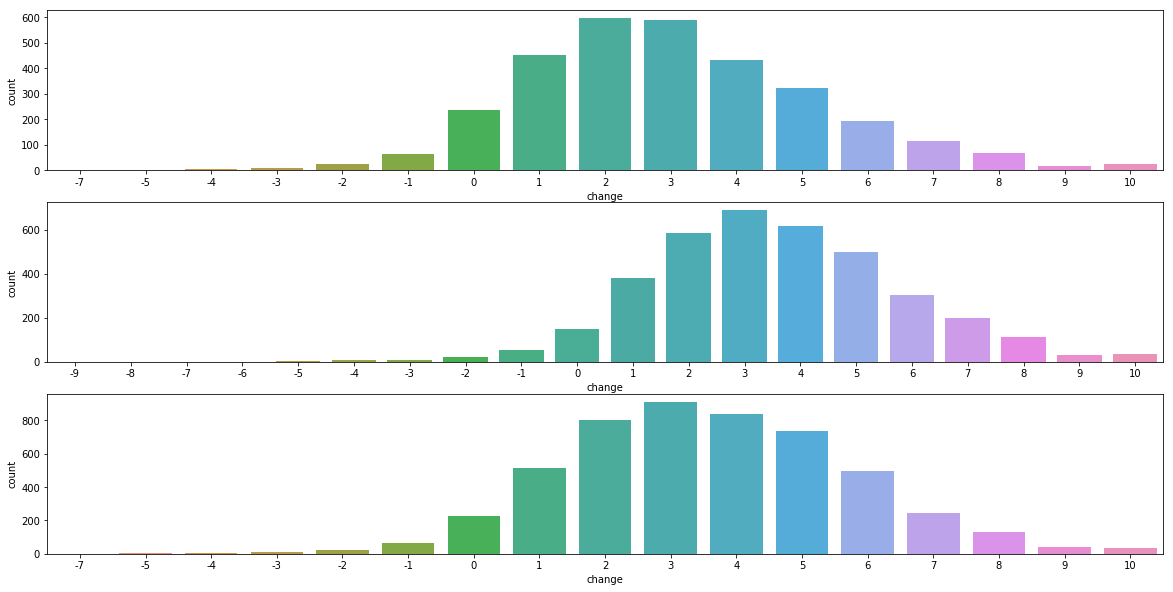

In [19]:
fig, axes = plt.subplots(3, figsize = (20,10),sharex='row') # Size

sns.countplot(df_depression['change'], ax= axes[0])
sns.countplot(df_stress['change'], ax = axes[1])
sns.countplot(df_anxiety['change'], ax = axes[2]);

# Cleaning DF

In [20]:
df_anxiety['symptom'] = 'anxiety'
df_depression['symptom'] = 'depression'
df_stress['symptom'] = 'stress'

df_raw = pd.concat([df_depression,df_anxiety,df_stress])
df = df_raw.reset_index().drop('index', axis = 1)

# Removing data with high potential for falsely provided information
mask = df['% cbd'] >= 0  # I'm not sure of how a product could have negative amounts of something.
df = df[mask]
mask = df['% thc'] >= 0 
df = df[mask]
mask = df['age'].abs() < 90
df = df[mask]
mask = df['time lag (min)'] <= 180 # After three hours [I suspect an increase in questionable validity]
df = df[mask]

df.to_csv('./data/cannabis_for_tableau.csv', index=False)



In [21]:
df = pd.get_dummies(df)
df.rename({
    'session/time'              : 'session', # This appears to be the number of times at this point that a user has tracked effects
    'time lag (min)'            : "time_lag",
    '% thc'                     : 'thc_%', 
    '% cbd'                     : 'cbd_%',
    'admin_method_Concentrate'  : 'concentrate',
    'admin_method_Dab Bubbler'  : 'dab_bubbler',
    'admin_method_Dab Portable' : 'dab_portable',
    'admin_method_Smoke'        : 'smoke',
    'admin_method_Vape'         : 'vape',
    'symptom_anxiety'           : 'symptom_a',
    'symptom_depression'        : 'symptom_d',
    'symptom_stress'            : 'symptom_s'
}, axis = 1, inplace = True)

In [ ]:
df.to_csv('./data/all_symptoms_cleaned.csv', index=False)

# ML DF EDA

In [22]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
session,10065.0,16.337506,23.878303,1.00,2.0,7.00,20.0,196.0
userid,10065.0,2687.544163,1277.586521,93.00,1670.0,2717.00,3633.0,5578.0
gender,10065.0,0.514456,0.499816,0.00,0.0,1.00,1.0,1.0
age,10065.0,33.161749,9.289252,18.00,25.0,33.00,39.0,87.0
dose,10065.0,6.247789,3.044516,1.00,4.0,6.00,10.0,10.0
time_lag,10065.0,34.534903,28.122963,0.10,20.8,23.90,40.6,179.8
thc_%,10065.0,15.973149,8.993642,0.04,12.0,17.70,19.9,100.0
cbd_%,10065.0,2.980585,6.441241,0.00,0.0,0.07,1.0,99.0
before,10065.0,5.970492,2.065892,1.00,5.0,6.00,7.0,10.0
after,10065.0,2.535420,2.138061,0.00,1.0,2.00,4.0,10.0


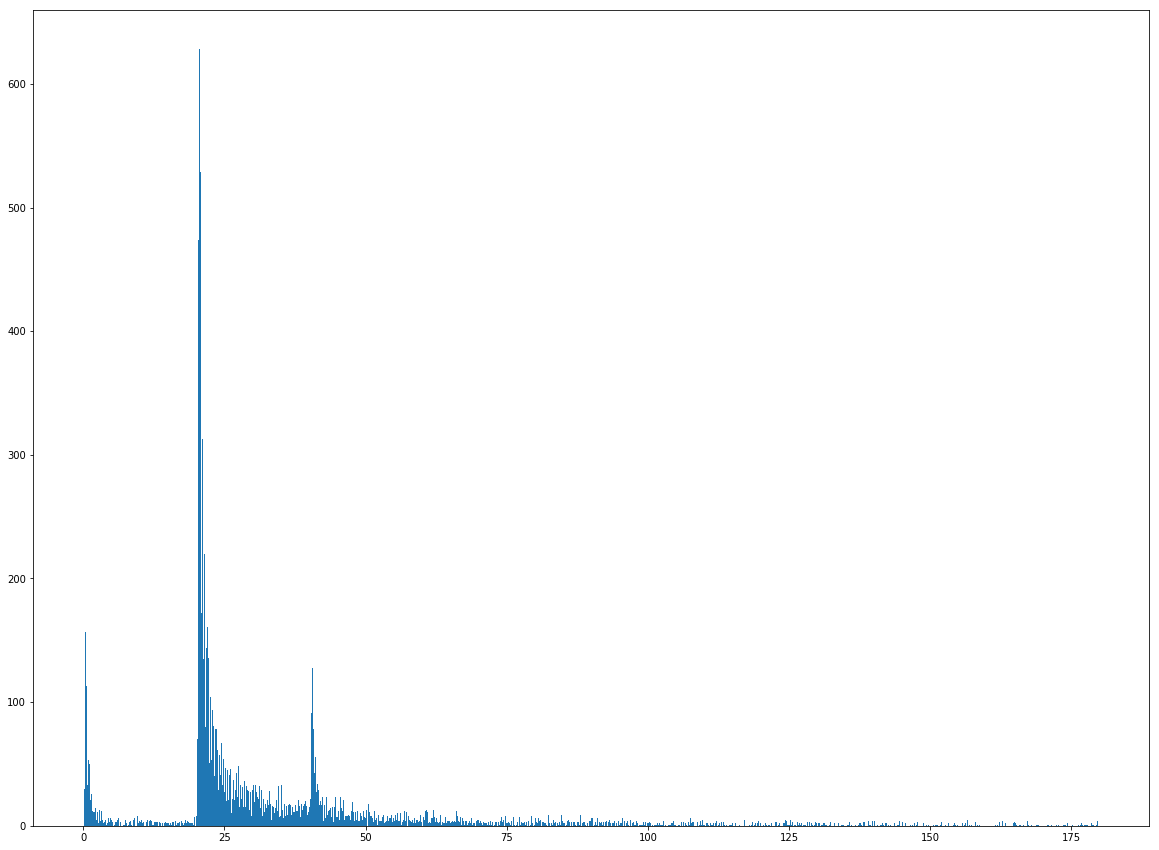

In [23]:
plt.figure(figsize = (20,15))
plt.hist(df['time_lag'],bins = len(df['time_lag'].value_counts()));

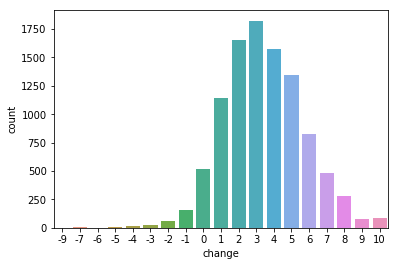

In [24]:
sns.countplot(df['change']);

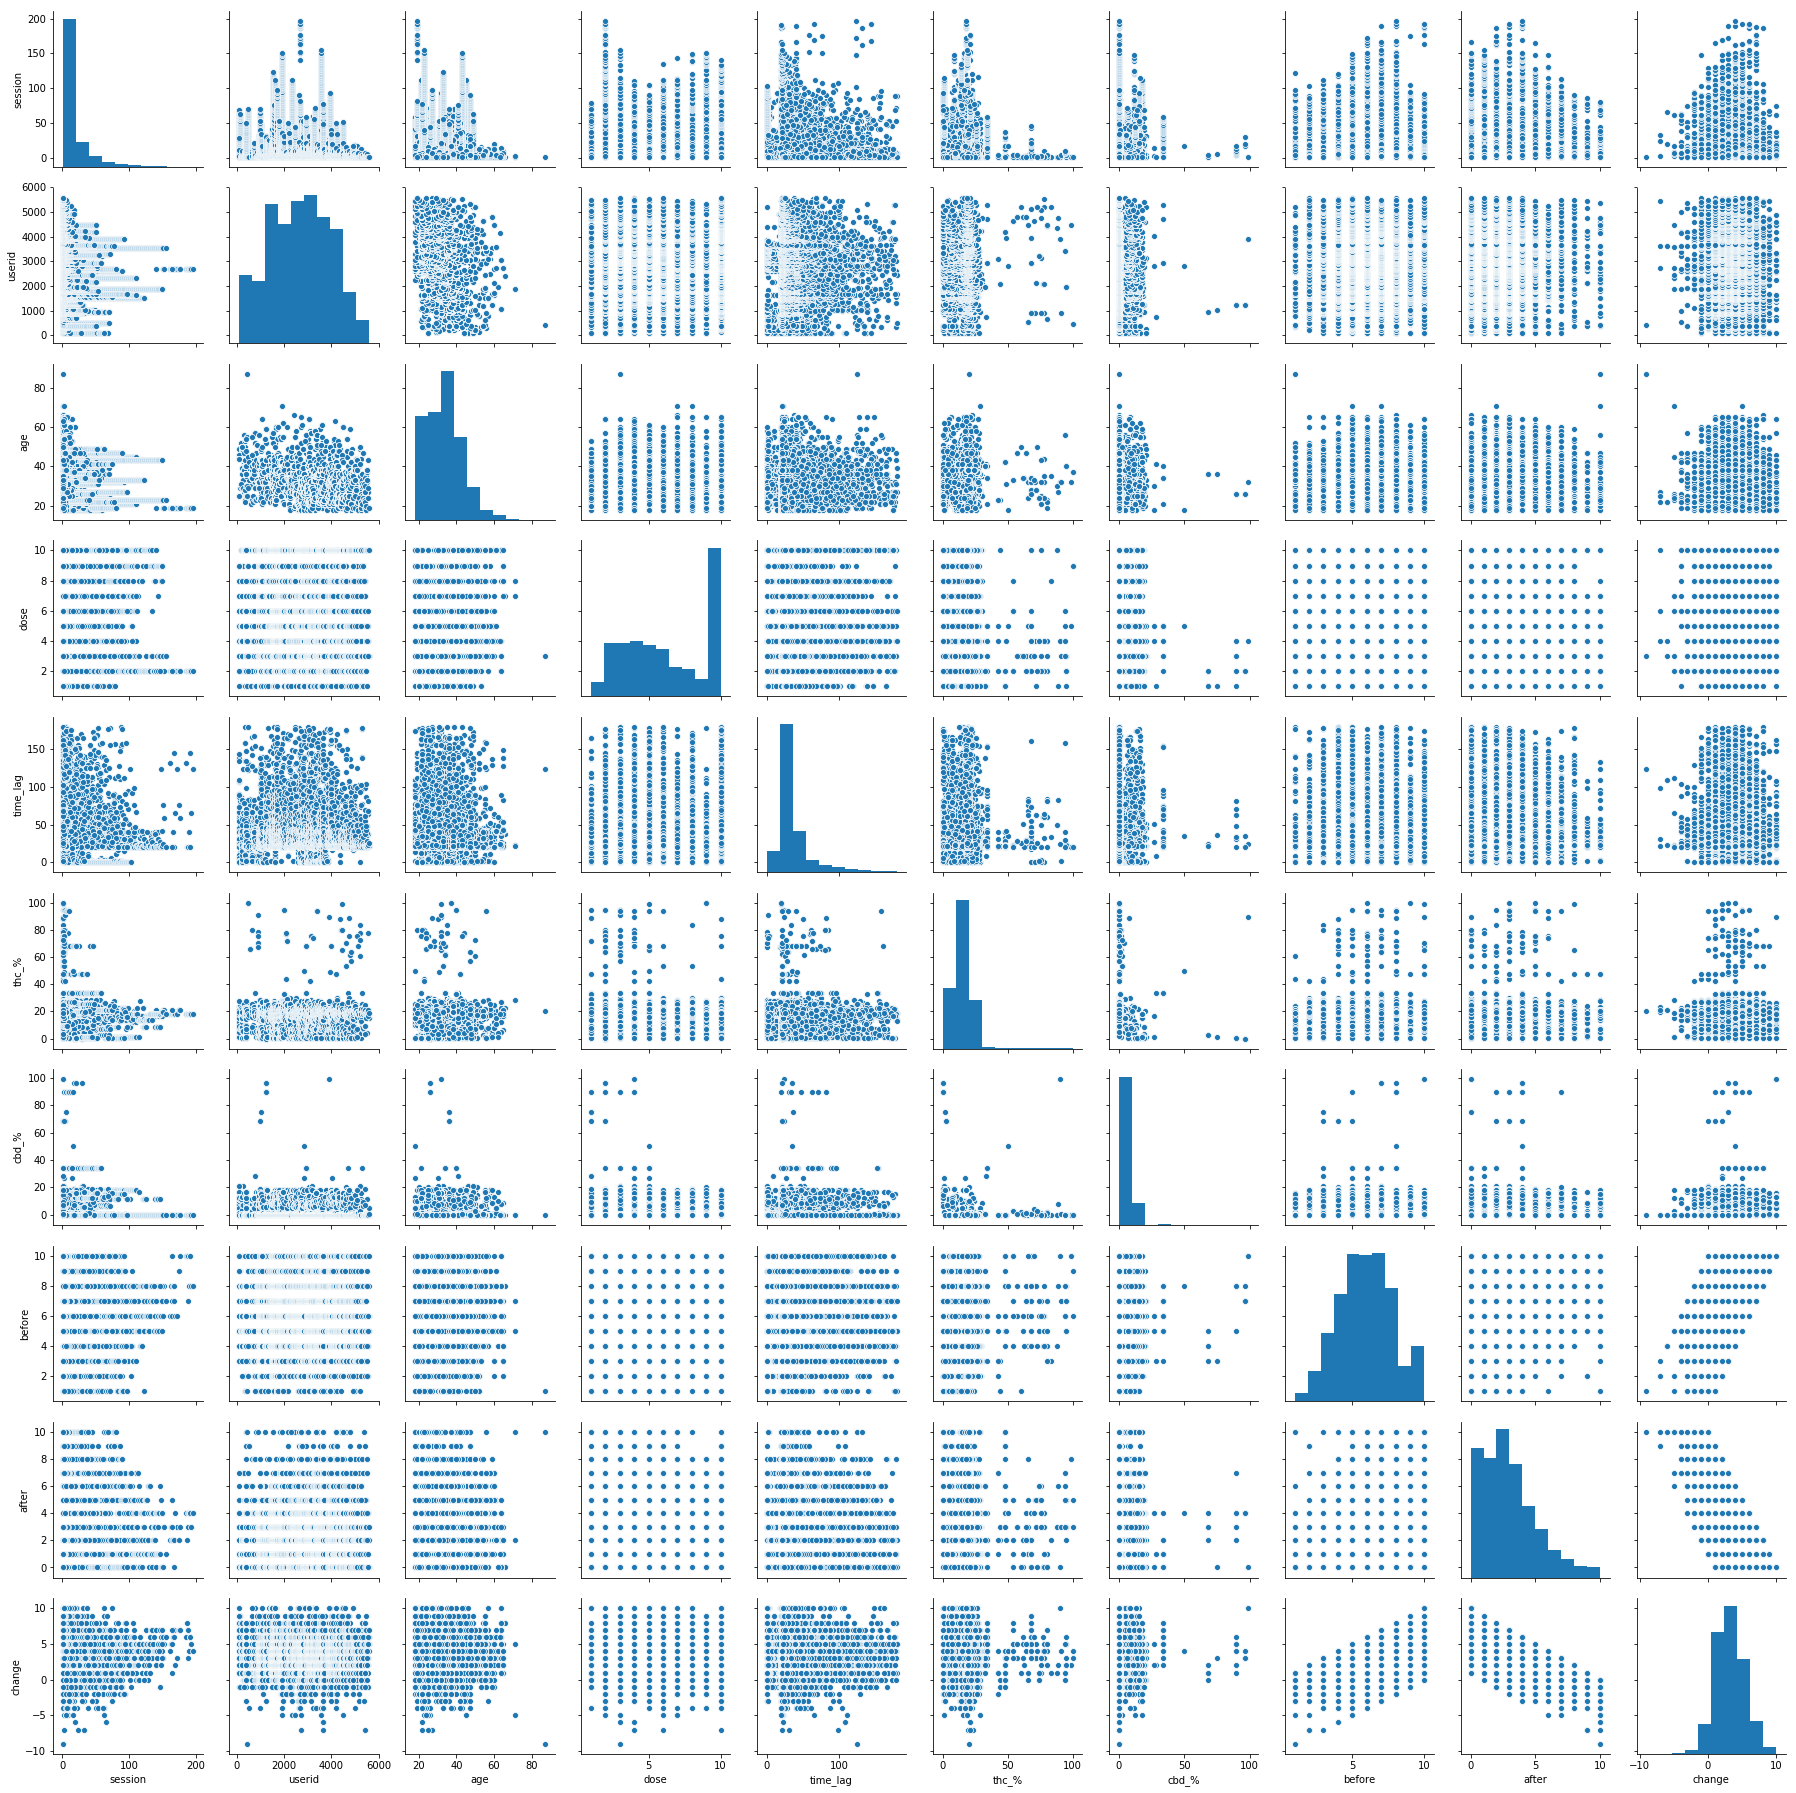

In [25]:
df_short = df.drop(['gender','symptom_a', 'symptom_d',
       'symptom_s', 'concentrate', 'dab_bubbler',
       'dab_portable', 'smoke', 'vape'], axis = 1)
sns.pairplot(df_short);

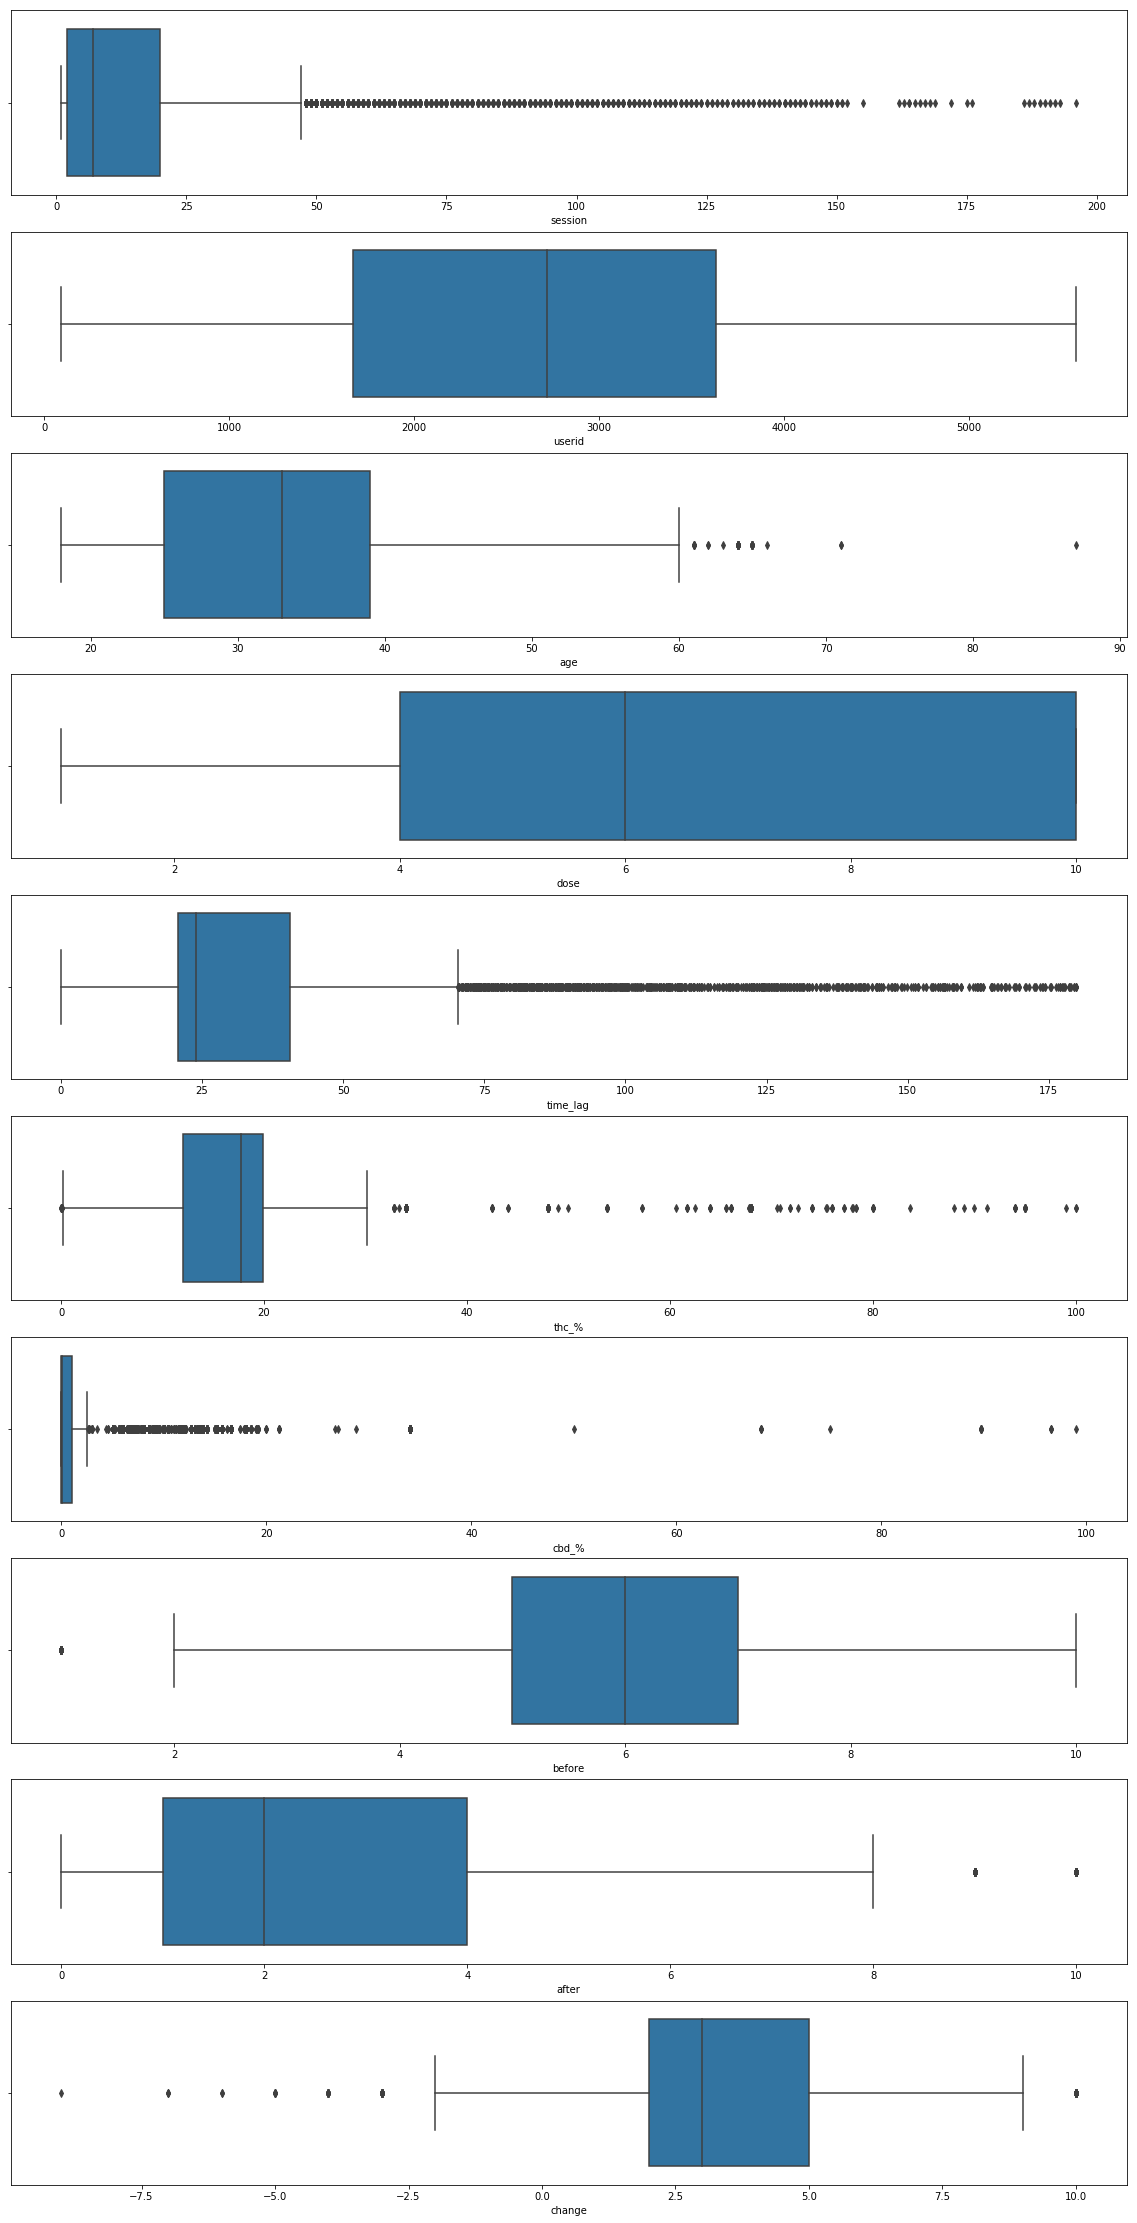

In [26]:
fig, axes = plt.subplots(len(df_short.columns),     
                   figsize = (20,40)) # Size
count = 0
for col in df_short.columns:
    sns.boxplot(df_short[col], ax = axes[count])
    count += 1

In [27]:
for name in df.columns:
    print('------------------------------------')
    print(name)
    print('')
    test = df.corrwith(df[name])
    mask = test.abs().between(0.1,0.9999)
    print(test[mask].sort_values(ascending=False))
print('------------------------------------')

------------------------------------
session

vape         0.147151
symptom_a    0.120766
userid      -0.138369
symptom_s   -0.141446
smoke       -0.142203
dtype: float64
------------------------------------
userid

smoke      0.230702
session   -0.138369
vape      -0.237709
age       -0.249398
dtype: float64
------------------------------------
gender

after     0.226095
before    0.108913
change   -0.114126
dose     -0.156066
dtype: float64
------------------------------------
age

vape      0.297020
userid   -0.249398
smoke    -0.263524
dtype: float64
------------------------------------
dose

before         0.124419
concentrate   -0.149211
gender        -0.156066
dtype: float64
------------------------------------
time_lag

Series([], dtype: float64)
------------------------------------
thc_%

concentrate    0.285345
vape          -0.128978
cbd_%         -0.451800
dtype: float64
------------------------------------
cbd_%

concentrate    0.112221
smoke         -0.119134
thc_%       

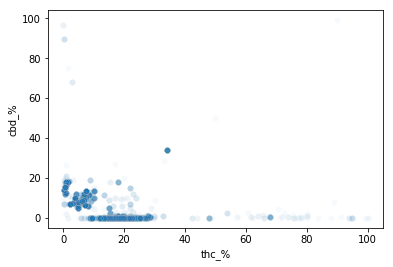

In [28]:

sns.scatterplot(df['thc_%'],df['cbd_%'],alpha=0.03);

In [29]:
print('Number of users in study:', len(df['userid'].value_counts())) # (Post data cleaning)

Number of users in study: 1062


In [446]:
mask = df['change'] >= -2
#X = df[mask].drop(['after', 'change','symptom_a','symptom_d','symptom_s', '% thc',
#                   '% cbd', 'userid', 'dose', 'session/time', 'dose', 'time lag (min)',
#         'admin_method_Dab Bubbler','admin_method_Dab Portable'], axis = 1)
X = df[mask][['before', 'symptom_a']]
y = df[mask]['change']


X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.33, stratify = y, random_state=42)
model = LinearRegression().fit(X_train, y_train)

def rmse_score(model, 
               X_train = X_train,
               X_test = X_test,
               y_train = y_train,
               y_test = y_test):
    train_score = mean_squared_error(y_true = y_train,
                                     y_pred = model.predict(X_train)) ** 0.5
    test_score = mean_squared_error(y_true = y_test,
                                    y_pred = model.predict(X_test)) ** 0.5
    print(str(model)[0:20])
    print("Train:" + str(train_score))
    print("Test :" + str(test_score))
    return

In [447]:
rmse_score(model)

LinearRegression(cop
Train:1.8850196695477537
Test :1.8955568076812463



In [343]:
rmse_score(model)

LinearRegression(cop
Train:1.8164340586611551
Test :1.810796081988613



In [294]:
rmse_score(model)

LinearRegression(cop
Train:2.1287358440261346
Test :2.1350915870583083



Sections:
    1.) Cleaning for Tableau
    2.) Cleaning for Machine Learning
    3.) Modeling for insights
    4.) Neural Network

## Code Recycling Bin
- For when I'm not yet ready to delete certain old code.

In [ ]:
# Basic EDA

df.dtypes                           # Data Types of cols
df.column.unique()                  # Unique Values in col
df.describe().T                     # Summary Stats
df.info                             # Info
df['column'].value_counts(normalize=True)

In [ ]:
# Graph Alterations
# Colors: plt.colors.cnames


# For layering on top:
plt.hist(df['column_1'], color='g')
plt.hist(df['column_2'], color='b')

# For layering next to:
fig, ax = plt.subplots(2, 
                    sharex = True,  # Scale x together
                    sharey = True,    
                   figsize = (1,1)) # Size
ax[0].hist(df['column_1'],          # 
           bins = 10,               # Bins
           color='b',               # Color
           alpha = 0.5,             # Transparancy
           label = 'col_1')         # For .legend()
ax[1].hist(df['column_2'])          # 

# Labels for Words
plt.xlabel("measure",               # Alt: .ylabel
           position = (0,0),        # (x-pos, y-pos)?
           ha = 'left',             # Horizontal
           color = 'grey') # (x,y)

plt.legend()
plt.title()                         # Title ~= Subtitle
plt.suptitle("subtitle\n.",         # Subtitle
             position = (0,1),      # Position
             ha = 'left',           # Horizontal
             fontsize=16,           # Size, Font
             va = 'top');           # Vertical

In [ ]:
# List of all different graphs we have available

# WTF ARE THESE THINGS!?!?
matplotlib.Button
plt.Figure
plt.Polygon
plt.axis
plt.draw
plt.draw_if_interactive
plt.eventplot
plt.matplotlib.widgets
plt.plot_date
plt.specgram
plt.spectral # Spectral Color Map!? :D
plt.stackplot
plt.subplot
plt.table
plt.waitforbuttonpress
plt.xcorr

# Eaily usable plots
plt.boxplot
plt.hist
plt.hist2d
plt.plot
plt.scatter
plt.violinplot

sns.jointplot()
sns.pairplot()
sns.puppyplot()
sns.interactplot()
sns.countplot()

# Heatmap
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True)

# Isolating half or above a threshold heatmaps